In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import UnivariateSpline
import os
import cv2
import glob
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

## 6 Parameters

Perform Fitting and Save CSV Results

In [2]:
def fit6(file, csv_output_path, T, indices, starting_column):
    
    data = pd.read_csv(file)
    # Define the double Gaussian function
    def f_func(T, C1, C2, C3, C4, C5, C6):
        return (C1 * np.exp(-C2 * T) + C3 +
                C4 * np.exp(-((T - C5) / C6)**2))

    # Initialize variables
    fitted_parameters = []
    r_squared_values = []
    peeq_values = []

    # Perform fitting for each row
    for j, i in enumerate(indices):
        if i != 0:
            stress = data.iloc[i, starting_column:].values
            initial_guess = [1, 0.005, 0.7, 0.2, 550, 140]
            bounds = ([0, 0.0001, 0, 0, 0, 100], [3., 0.01, 1, 2, 600, 350])
       
            
            # Perform curve fitting
            params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, maxfev=100000)
            residuals = stress - f_func(T, *params)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress - np.mean(stress))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Save results
            fitted_parameters.append([data.iloc[i, 0], *params, r_squared])
            r_squared_values.append(r_squared)
            peeq_values.append(data.iloc[i, 0])

    # Save all results to CSV
    columns = ['PEEQ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'R²']
    fitted_parameters_df = pd.DataFrame(fitted_parameters, columns=columns)
    fitted_parameters_df.to_csv(csv_output_path, index=False)
    print(f"Fitting results saved to '{csv_output_path}'")
    
    # Calculate R² statistics
    min_r2 = min(r_squared_values)
    max_r2 = max(r_squared_values)
    avg_r2 = np.mean(r_squared_values)
    peeq_min_r2 = peeq_values[r_squared_values.index(min_r2)]
    peeq_max_r2 = peeq_values[r_squared_values.index(max_r2)]

    # Calculate percentage of R² values below 0.99
    below = sum(1 for r2 in r_squared_values if r2 < 0.99)
    percentage_below = (below / len(r_squared_values)) * 100

    # Print R² statistics
    print("\nR² Statistics:")
    print(f"Smallest R²: {min_r2:.3f} (PEEQ: {peeq_min_r2:.5f})")
    print(f"Largest R²: {max_r2:.3f} (PEEQ: {peeq_max_r2:.5f})")
    print(f"Average R²: {avg_r2:.3f}")
    print(f"Percentage of R² values below 0.99: {percentage_below:.2f}%")

Generate PDF files and plots

In [3]:
def generate_pdf(result, file, output_pdf, T, starting_column, n):
    # Read the results from the saved CSV file
    results = pd.read_csv(result)
    original_data = pd.read_csv(file).iloc[1:]
    output_images_dir = f"plots_{output_pdf.split('.pdf')[0]}"

    # Create directory for plots
    os.makedirs(output_images_dir, exist_ok=True)

    # Initialize a PDF for storing plots
    pdf_pages = PdfPages(output_pdf)

    # Loop through the results to generate plots
    for index, row in results.iterrows():
        peeq = row['PEEQ']  
        params = row[1:-1].values  
        r_squared = row['R²']  

        # Extract the original data
        stress_original = original_data.iloc[index, starting_column:].values

        # Generate data for the fitted curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = (
            params[0] * np.exp(-params[1] * T_fit) + params[2] +
            params[3] * np.exp(-((T_fit - params[4]) / params[5])**2) 
        )

        # Plot both original data and fitted curve
        plt.figure(figsize=(4.5, 5))
        plt.ylim(0.8, n)
       
        plt.plot(T, stress_original, 'o', color='blue', label='Data')
       
        plt.plot(T_fit, stress_fit, '-', color='red', label='Fitted Curve')

        plt.xlabel('Temperature (K)', fontsize=12)
        plt.ylabel('Normalized Stress', fontsize=12)
        plt.title(f"Strain={peeq:.5f} (R² = {r_squared:.3f})", fontweight='bold', fontsize=12)
        
        plt.legend(
            [
                f'Data',
                f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
                f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f}'
            ],
            fontsize=10
        )

        # Save the current figure to the PDF
        pdf_pages.savefig()

        # Save the current figure as an image for video generation
        image_path = os.path.join(output_images_dir, f"plot_{index:03d}.png")
        plt.savefig(image_path, dpi=300) 
        plt.close()

    pdf_pages.close()
    print(f"PDF with original data and fitted curves saved as '{output_pdf}'")
    print(f"Plots saved in '{output_images_dir}'")


Generate PDF with specific strain values

In [4]:
def generate_combined_plot(result, file, T, starting_column, n, indices):
    # Read the results from the saved CSV file
    results = pd.read_csv(result)
    original_data = pd.read_csv(file).iloc[1:]
    
    # Define a list of colors
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Create a single figure for the combined plot with adjusted size
    plt.figure(figsize=(4.5,4))  

    # Lists to store custom legend handles
    data_handles = []
    fit_handles = []

    # Loop through the specified indices to generate plots
    for idx, index in enumerate(indices):
        row = results.iloc[index]
        peeq = row['PEEQ']  
        params = row[1:7].values  
        #r_squared = row['R²']  

        # Extract the original data
        stress_original = original_data.iloc[index, starting_column:].values

        # Generate data for the fitted curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = (
            params[0] * np.exp(-params[1] * T_fit) + params[2] +
            params[3] * np.exp(-((T_fit - params[4]) / params[5])**2) 
        )

       
        color = colors[idx % len(colors)]  

        # Plot 
        plt.plot(T, stress_original, 'o', color=color, markersize=5)

        plt.plot(T_fit, stress_fit, '-', color=color, linewidth=1)

        data_handles.append(
            mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=5, label=f"Data")
        )
        fit_handles.append(
            mlines.Line2D([], [], color=color, linestyle='-', linewidth=1, label=f"Fit (Strain={peeq:.5f})")
        )

  
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('Normalized Stress', fontsize=12)
    #plt.title("Combined Plot for Selected Indices", fontweight='bold', fontsize=12)
    plt.ylim(0.8, n)

    plt.legend(handles=data_handles + fit_handles, fontsize=10, loc='upper right', ncol=2)

    plt.show()

Generate video

In [5]:
def generate_video(output_video_path, step=4):
    output_images_dir = f"plots_{output_video_path.split('.mp4')[0]}"
    #output_video_path = f"{n}_Parameters_{file}_final_step_{step}.mp4"

    # Get the list of image files
    image_files = sorted(glob.glob(os.path.join(output_images_dir, "plot_*.png")))

    # Filter to include only every `step` plot
    selected_images = image_files[::step]

    # Check if there are any images
    if not selected_images:
        print("No images found in the plots directory.")
        return

    frame = cv2.imread(selected_images[0])
    height, width, layers = frame.shape

    # Define the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    video = cv2.VideoWriter(output_video_path, fourcc, 5, (width, height))  # 2 FPS
    #frame = 3

    # Write each selected image to the video
    for image_file in selected_images:
        frame = cv2.imread(image_file)
        video.write(frame)

    video.release()
    print(f"Video saved as '{output_video_path}'")

## Strain rate 0.0001

In [6]:
file_0001 = r'..\Fitted_FC_TmpDpn_RD_StrRt0.0001_ref.csv'
output_csv_path_0001 = f'6_Parameters_0.0001.csv'


#T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
#starting_column = 6 #other strain-rates
starting_column = 8 #0.0001

In [7]:
fit6(file_0001, output_csv_path_0001, T, indices, starting_column)

Fitting results saved to '6_Parameters_0.0001.csv'

R² Statistics:
Smallest R²: 0.971 (PEEQ: 0.00011)
Largest R²: 1.000 (PEEQ: 0.03600)
Average R²: 0.994
Percentage of R² values below 0.99: 0.25%


In [8]:
output_pdf = f'6_Parameters_0.0001.pdf'
generate_pdf(output_csv_path_0001, file_0001, output_pdf, T, starting_column,2.4)

PDF with original data and fitted curves saved as '6_Parameters_0.0001.pdf'
Plots saved in 'plots_6_Parameters_0.0001'


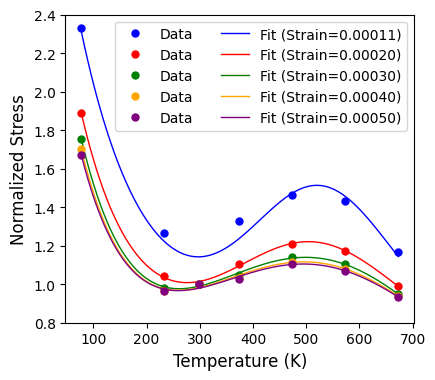

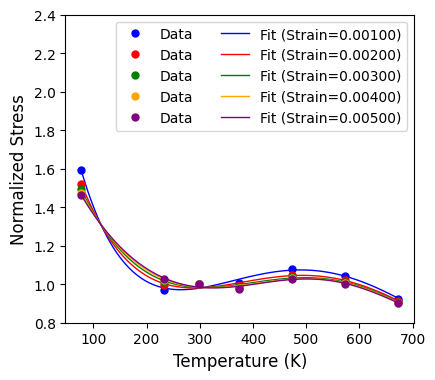

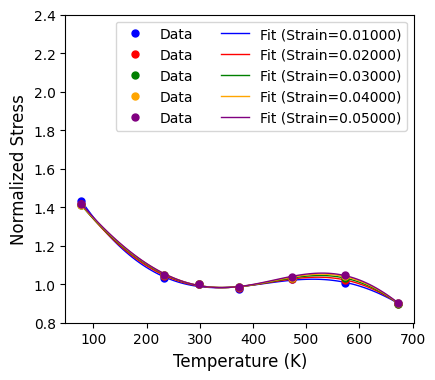

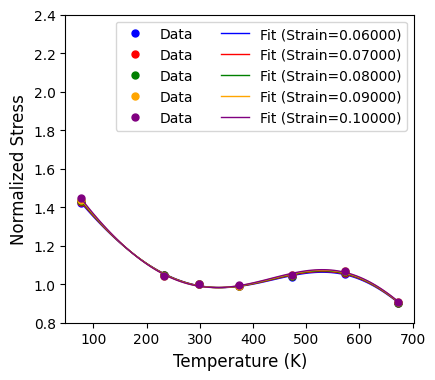

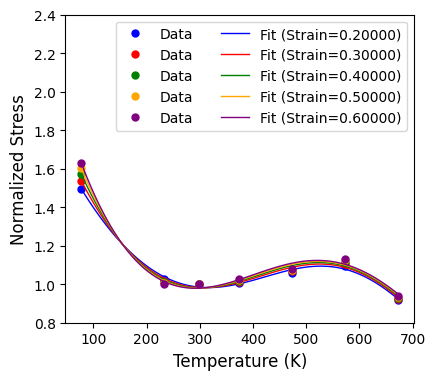

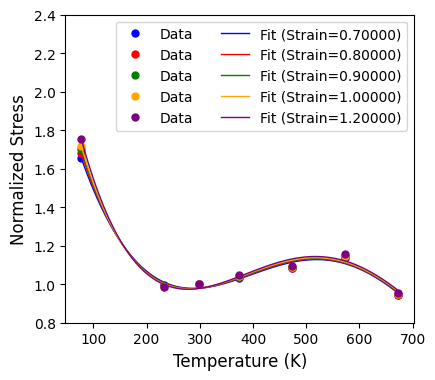

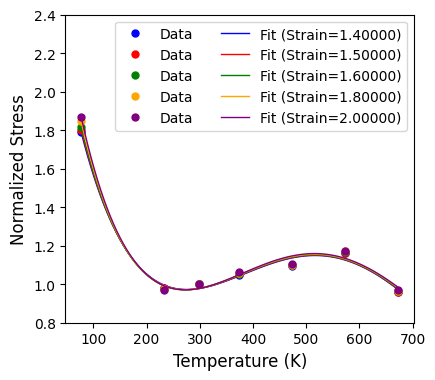

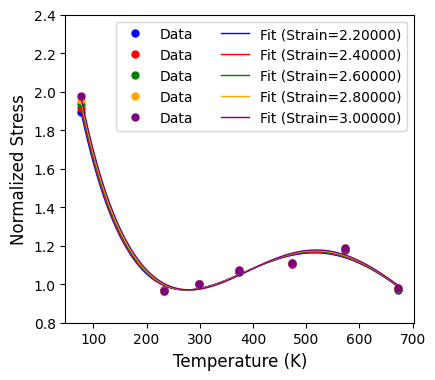

In [9]:

indices = np.array([0,1,2, 3, 4])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([9,10,11, 12, 13])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([14,24,34, 44, 54])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([64,74,84, 94, 104])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([114,124,134, 144, 154])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([164,174,184, 194, 214])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([234,244,254, 274, 294])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([314,334,354, 374, 394])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

In [10]:
output_video = f'6_Parameters_0.0001.mp4'
generate_video(output_video,step=6)

Video saved as '6_Parameters_0.0001.mp4'


## Strain rate 0.001

In [11]:
file_001 = r'..\Fitted_FC_TmpDpn_RD_StrRt0.001_ref.csv'
output_csv_path_001 = f'6_Parameters_0.001.csv'


T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001


In [12]:
fit6(file_001, output_csv_path_001, T, indices, starting_column)

C:\Temp\ipykernel_24180\1477655727.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, maxfev=100000)


Fitting results saved to '6_Parameters_0.001.csv'

R² Statistics:
Smallest R²: 0.685 (PEEQ: 0.00011)
Largest R²: 1.000 (PEEQ: 0.02900)
Average R²: 0.998
Percentage of R² values below 0.99: 1.52%


In [13]:
output_pdf = f'6_Parameters_0.001.pdf'
generate_pdf(output_csv_path_001, file_001, output_pdf, T, starting_column,1.5)

PDF with original data and fitted curves saved as '6_Parameters_0.001.pdf'
Plots saved in 'plots_6_Parameters_0.001'


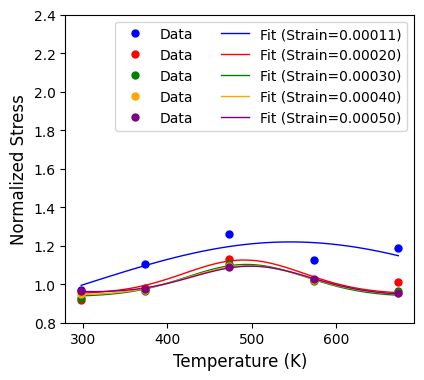

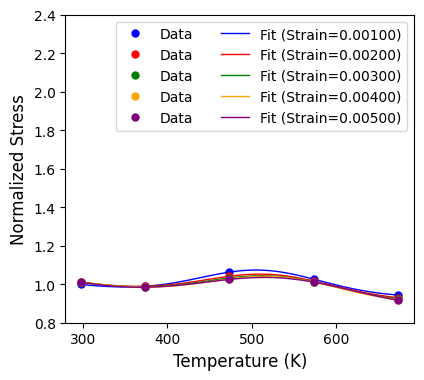

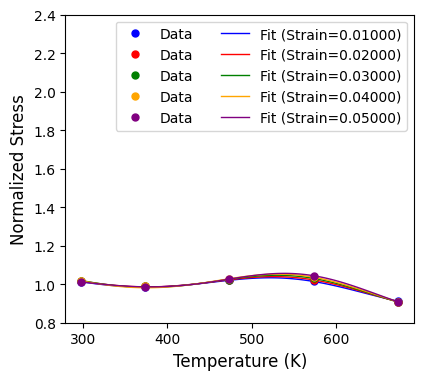

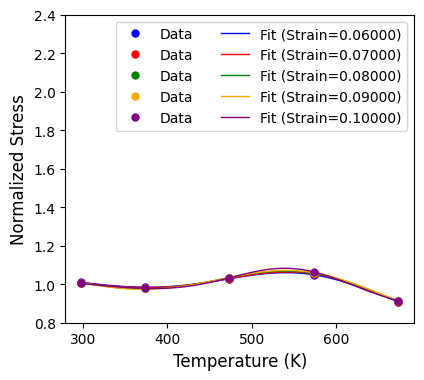

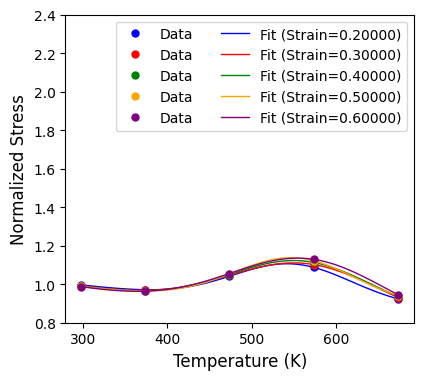

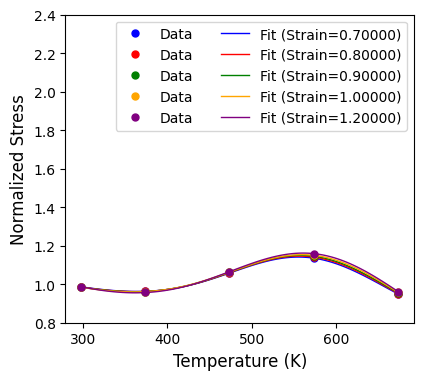

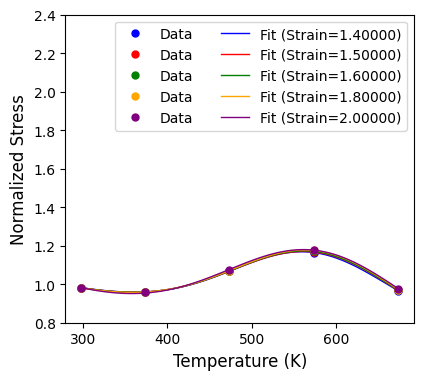

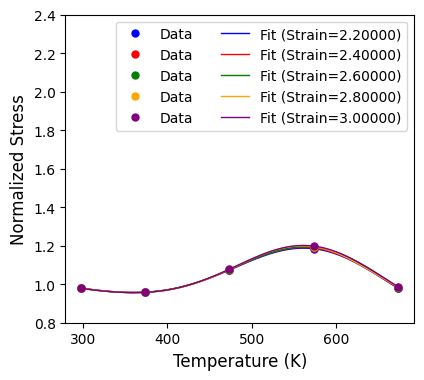

In [14]:
indices = np.array([0,1,2, 3, 4])
generate_combined_plot(output_csv_path_001, file_001, T, starting_column, 2.4, indices)

indices = np.array([9,10,11, 12, 13])
generate_combined_plot(output_csv_path_001, file_001, T, starting_column, 2.4, indices)

indices = np.array([14,24,34, 44, 54])
generate_combined_plot(output_csv_path_001, file_001, T, starting_column, 2.4, indices)

indices = np.array([64,74,84, 94, 104])
generate_combined_plot(output_csv_path_001, file_001, T, starting_column, 2.4, indices)

indices = np.array([114,124,134, 144, 154])
generate_combined_plot(output_csv_path_001, file_001, T, starting_column, 2.4, indices)

indices = np.array([164,174,184, 194, 214])
generate_combined_plot(output_csv_path_001, file_001,  T, starting_column, 2.4, indices)

indices = np.array([234,244,254, 274, 294])
generate_combined_plot(output_csv_path_001, file_001, T, starting_column, 2.4, indices)

indices = np.array([314,334,354, 374, 394])
generate_combined_plot(output_csv_path_001, file_001,  T, starting_column, 2.4, indices)

In [15]:
output_video = f'6_Parameters_0.001.mp4'
generate_video(output_video,step=6)

Video saved as '6_Parameters_0.001.mp4'


## Strain rate 0.01

In [16]:
file_01 = r'..\Fitted_FC_TmpDpn_RD_StrRt0.01_ref.csv'
output_csv_path_01 = f'6_Parameters_0.01.csv'


T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001

In [17]:

fit6(file_01, output_csv_path_01, T, indices, starting_column)

C:\Temp\ipykernel_24180\1477655727.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, maxfev=100000)


Fitting results saved to '6_Parameters_0.01.csv'

R² Statistics:
Smallest R²: 0.870 (PEEQ: 0.00011)
Largest R²: 1.000 (PEEQ: 0.03100)
Average R²: 0.996
Percentage of R² values below 0.99: 14.94%


In [18]:
output_pdf = f'6_Parameters_0.01.pdf'
generate_pdf(output_csv_path_01, file_01, output_pdf, T, starting_column,1.6)

PDF with original data and fitted curves saved as '6_Parameters_0.01.pdf'
Plots saved in 'plots_6_Parameters_0.01'


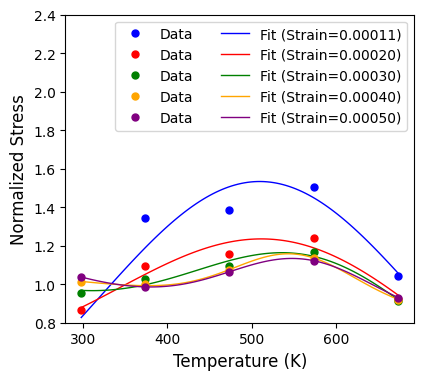

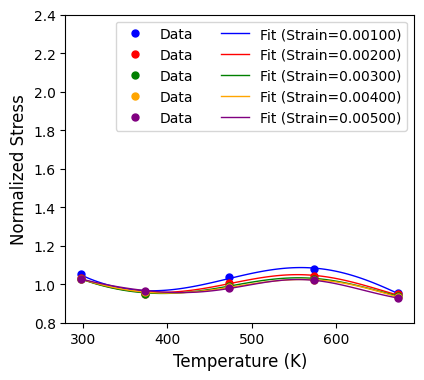

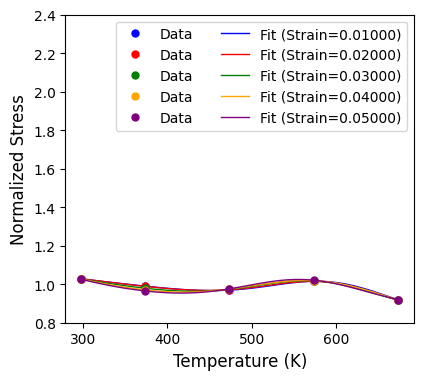

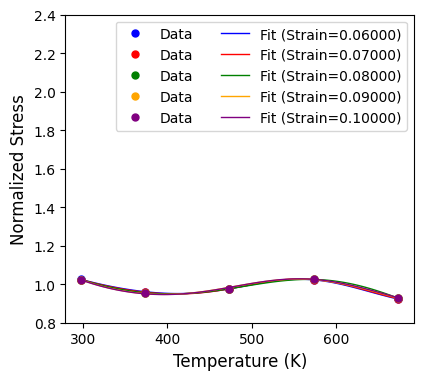

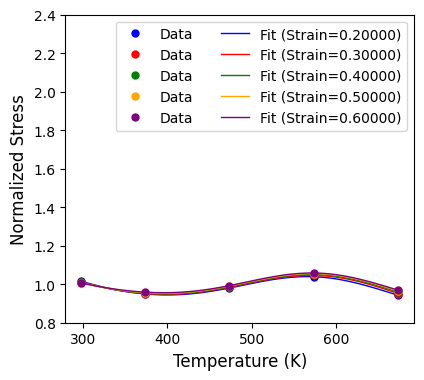

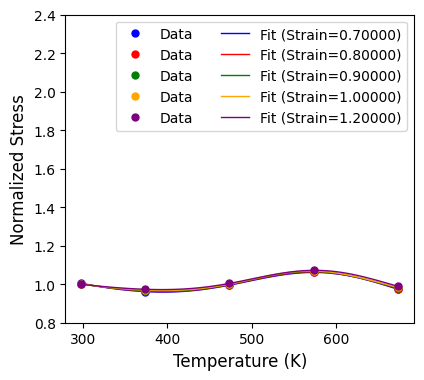

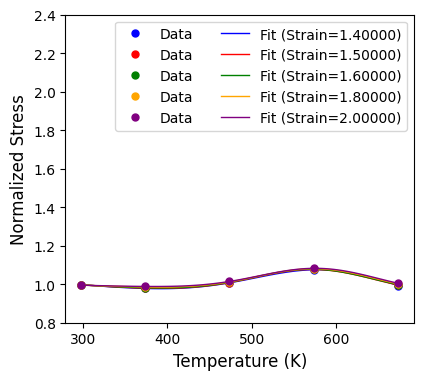

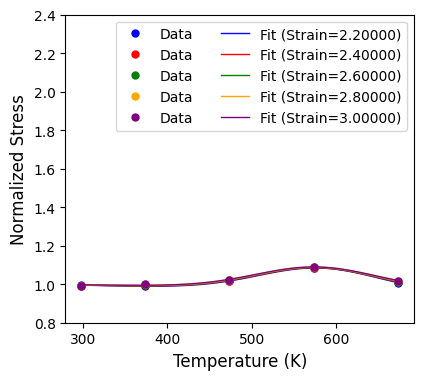

In [19]:
indices = np.array([0,1,2, 3, 4])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

indices = np.array([9,10,11, 12, 13])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

indices = np.array([14,24,34, 44, 54])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

indices = np.array([64,74,84, 94, 104])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

indices = np.array([114,124,134, 144, 154])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

indices = np.array([164,174,184, 194, 214])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

indices = np.array([234,244,254, 274, 294])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

indices = np.array([314,334,354, 374, 394])
generate_combined_plot(output_csv_path_01, file_01, T, starting_column, 2.4, indices)

In [20]:
output_video = f'6_Parameters_0.01.mp4'
generate_video(output_video,step=6)

Video saved as '6_Parameters_0.01.mp4'


## Strain rate 0.1

In [21]:
file_1 = r'..\Fitted_FC_TmpDpn_RD_StrRt0.1_ref.csv'
output_csv_path_1 = f'6_Parameters_0.1.csv'


T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001

In [22]:
fit6(file_1, output_csv_path_1, T, indices, starting_column)

C:\Temp\ipykernel_24180\1477655727.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, maxfev=100000)


Fitting results saved to '6_Parameters_0.1.csv'

R² Statistics:
Smallest R²: 0.449 (PEEQ: 0.08800)
Largest R²: 1.000 (PEEQ: 0.01600)
Average R²: 0.987
Percentage of R² values below 0.99: 5.06%


In [23]:
output_pdf = f'6_Parameters_0.1.pdf'
generate_pdf(output_csv_path_1, file_1, output_pdf, T, starting_column,1.6)

PDF with original data and fitted curves saved as '6_Parameters_0.1.pdf'
Plots saved in 'plots_6_Parameters_0.1'


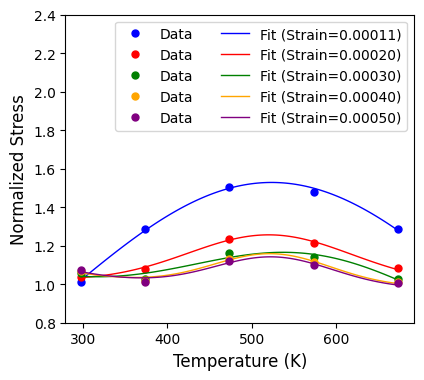

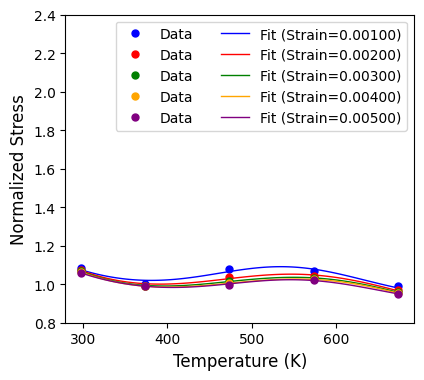

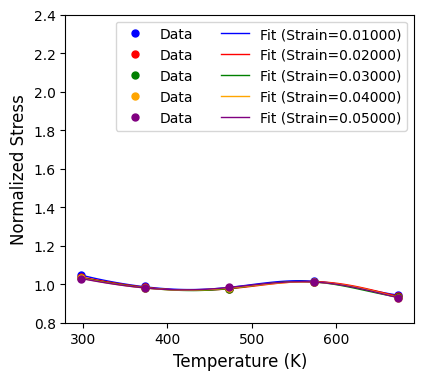

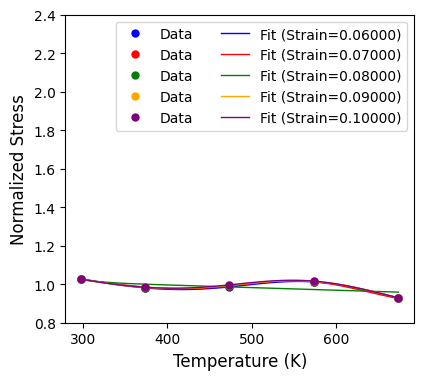

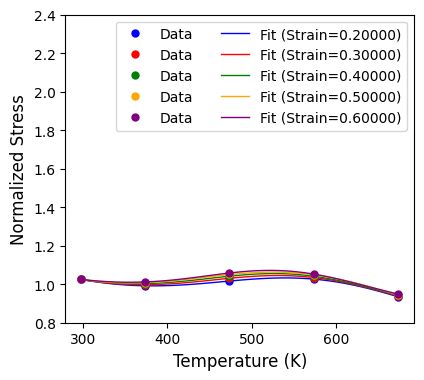

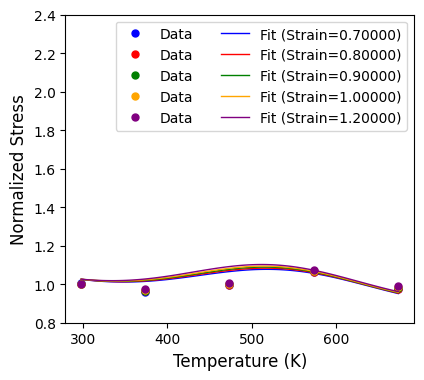

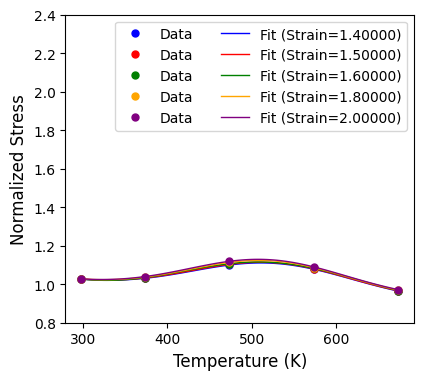

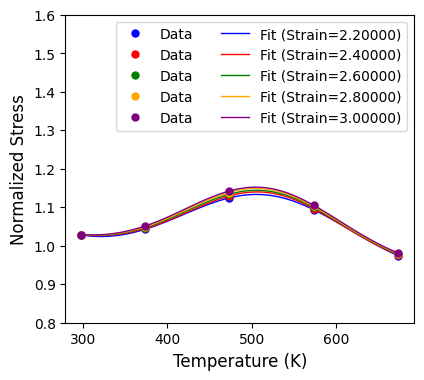

In [ ]:
indices = np.array([0,1,2, 3, 4])
generate_combined_plot(output_csv_path_1, file_1, T, starting_column, 2.4, indices)

indices = np.array([9,10,11, 12, 13])
generate_combined_plot(output_csv_path_1, file_1,  T, starting_column, 2.4, indices)

indices = np.array([14,24,34, 44, 54])
generate_combined_plot(output_csv_path_1, file_1, T, starting_column, 2.4, indices)

indices = np.array([64,74,84, 94, 104])
generate_combined_plot(output_csv_path_1, file_1, T, starting_column, 2.4, indices)

indices = np.array([114,124,134, 144, 154])
generate_combined_plot(output_csv_path_1, file_1, T, starting_column, 2.4, indices)

indices = np.array([164,174,184, 194, 214])
generate_combined_plot(output_csv_path_1, file_1, T, starting_column, 2.4, indices)

indices = np.array([234,244,254, 274, 294])
generate_combined_plot(output_csv_path_1, file_1, T, starting_column, 2.4, indices)

indices = np.array([314,334,354, 374, 394])
generate_combined_plot(output_csv_path_1, file_1,  T, starting_column, 1.6, indices)

In [25]:
output_video = f'6_Parameters_0.1.mp4'
generate_video(output_video,step=6)

Video saved as '6_Parameters_0.1.mp4'


## Plot all C data

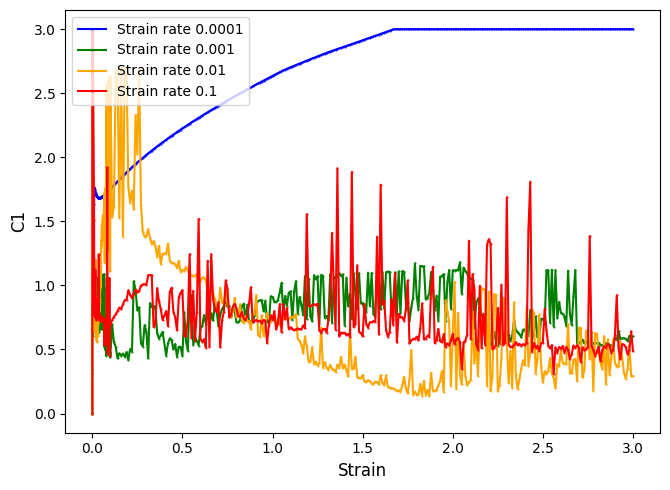

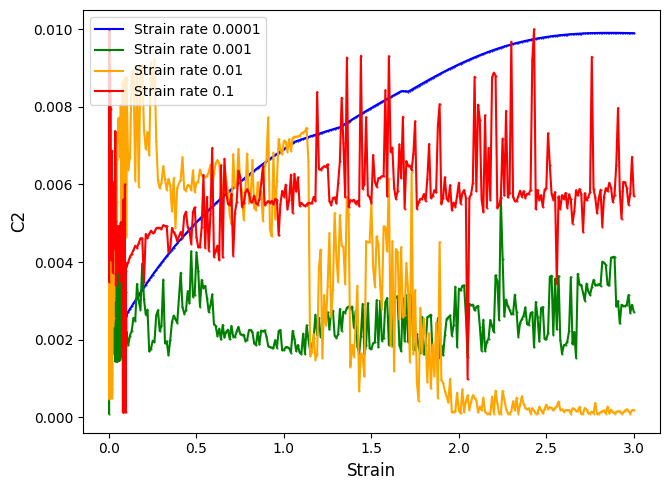

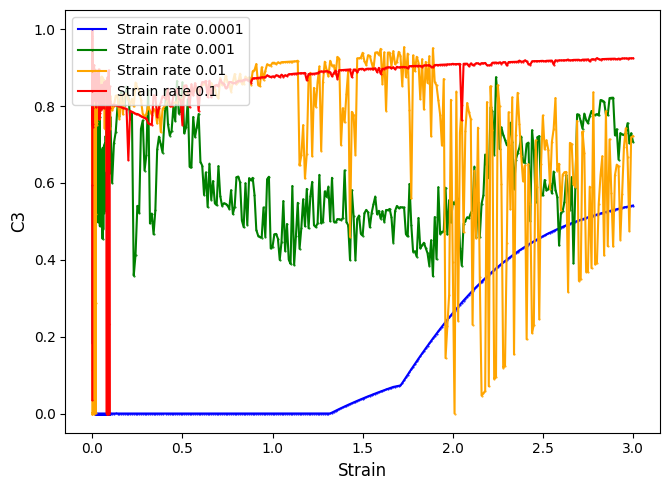

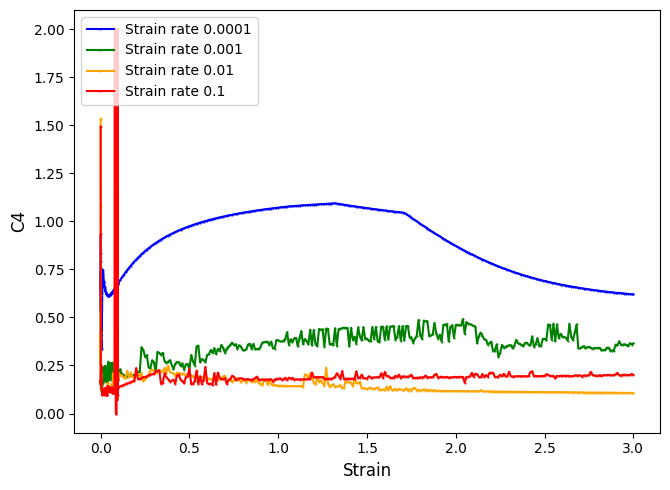

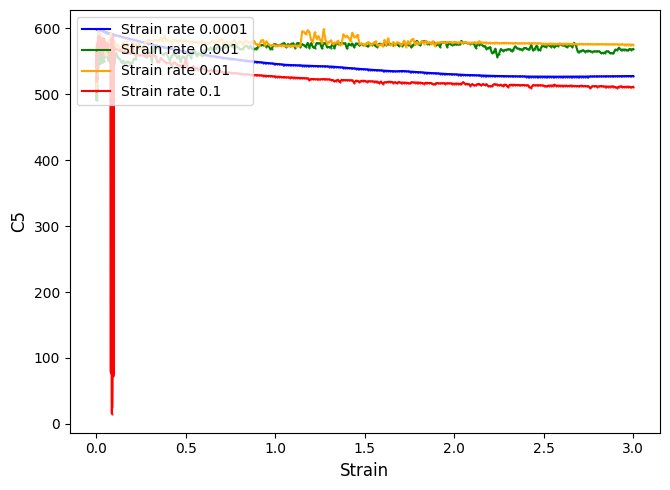

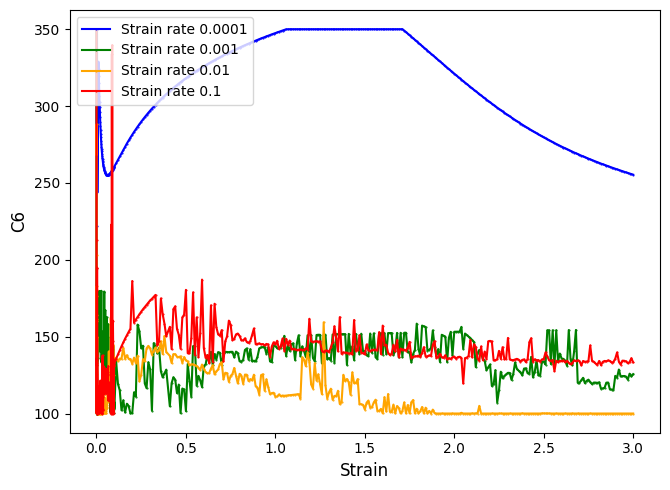

In [26]:
output_csv_path_1 = f'6_Parameters_0.1.csv'
output_csv_path_01 = f'6_Parameters_0.01.csv'
output_csv_path_001 = f'6_Parameters_0.001.csv'
output_csv_path_0001 = f'6_Parameters_0.0001.csv'


# List of files
files = [
    output_csv_path_0001, output_csv_path_001, output_csv_path_01, output_csv_path_1
]

# Specify the column names
x_column = 'PEEQ'
y_columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Specify the PEEQ bounds
peeq_lower_bound = 0
peeq_upper_bound = 3

# Colors for different datasets
colors = ['blue', 'green', 'orange', 'red','black','purple','red','pink','brown']

# Iterate over each y-column
for y_column in y_columns:
    plt.figure(figsize=(8, 5))
    for file, color in zip(files, colors):
        # Read the data
        data = pd.read_csv(file)

        # Filter data based on the PEEQ bounds
        filtered_data = data[
            (data[x_column] > peeq_lower_bound) &
            (data[x_column] <= peeq_upper_bound) &
            (data[x_column] != 0.4)  # Exclude strain = 0.4
        ]
        
        label_name = file.split('_0.')[-1].split('.csv')[0] # Extract text after 'RD'
        # Plot the data for the current file
        plt.plot(
            filtered_data[x_column],
            filtered_data[y_column],
            marker='o',
            linestyle='-',
            markersize=0.5, 
            label=f'Strain rate 0.{label_name}',
            color=color
        )

    plt.xlabel('Strain', fontsize=12)
    plt.ylabel(y_column, fontsize=12)
    #plt.title(f'{y_column} vs Strain for Different Strain Rates', fontweight='bold', fontsize=12)
    #plt.legend(loc='upper right', bbox_to_anchor=(3.75, 3))
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', frameon=True)
    plt.legend(fontsize=10, loc='upper left')
    #plt.grid(True)
    #plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()




## Find C-parameter function for Strain rate 0.0001

In [27]:
file_0001 = '6_Parameters_0.0001.csv'
data = pd.read_csv(file_0001)
x_column = 'PEEQ'
# Specify the PEEQ bounds
peeq_lower_bound = 0
peeq_upper_bound = 3

# Filter data based on the PEEQ bounds
#filtered_data = data[
    #(data[x_column] > peeq_lower_bound) & 
    #(data[x_column] <= peeq_upper_bound) & 
    #(data[x_column] != 0.4)  # Exclude strain = 0.4
#]
filtered_data = data[
    (data[x_column] > peeq_lower_bound) & 
    (data[x_column] <= peeq_upper_bound)]

In [28]:
def func_C(s, a, b, c, d, e, f, g, h, i, j):
    gaussian1 = a * np.exp(-((s - b)**2) / (2 * c**2))  # First Gaussian for initial increase
    decay = d * np.exp(-e * s)  # Exponential decay for rapid drop
    gaussian2 = f * np.exp(-((s - g)**2) / (2 * h**2))  # Second Gaussian for the rise
    logistic = i / (1 + np.exp(-j * (s - g)))  # Logistic function for final leveling off
    return gaussian1 + decay + gaussian2 + logistic

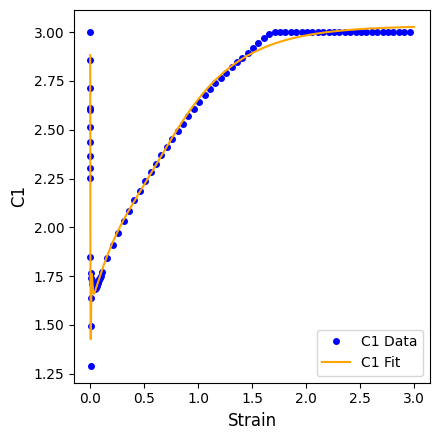

C1 Fit 
Q1=-11.311, Q2=-0.009, Q3=0.009,
P1=8.059, P2=202.742,
M1=0.245, M2=0.097, M3=0.271
N1=3.033, N2=2.158
Fitted parameters for C1:

R² Statistics:
R² Value for Fit: 0.998


In [29]:
y_column = 'C1'
strain = filtered_data[x_column].values
C1 = filtered_data[y_column].values

# Create a DataFrame to store the PEEQ and fitted C1 values
df_para_fit = pd.DataFrame({x_column: strain})


initial_guess = [
    5.0,    # a
    0.001,  # b
    0.005,  # c
    4.0,    # d
    100.0,  # e
    2.0,    # f
    0.1,    # g
    0.05,   # h
    1.0,    # i
    1     # j
]

params, _ = curve_fit(
    func_C, strain, C1, p0=initial_guess, maxfev=100000
)

# Generate fitted C1 values 
C1_fitted = func_C(strain, *params)
df_para_fit['C1'] = C1_fitted

# calculate r-squared value

residuals = C1 - C1_fitted
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((C1 - np.mean(C1)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.figure(figsize=(4.5,4.5))

# Plot data from peeq_upper_bound ti 0.01 (every 5th value)
lower_mask = (strain >= peeq_lower_bound) & (strain <= 0.01)
plt.plot(strain[lower_mask], C1[lower_mask], 'o', label='C1 Data (Full Range)', markersize=4,color='blue')

# Plot data from 1 to peeq_upper_bound (every 5th value)
upper_mask = (strain > 0.01) & (strain <= peeq_upper_bound)
plt.plot(strain[upper_mask][::5], C1[upper_mask][::5], 'o', label='_nolegend_', markersize=4,color='blue')

# Plot d fitted curve



plt.plot(strain, C1_fitted, '-', label='C1 Fit', color='orange')  # Fitted curve
plt.xlabel('Strain', fontsize=12)
plt.ylabel('C1', fontsize=12)
plt.legend([
    'C1 Data',     
    'C1 Fit'
        ], fontsize=10,loc='lower right')
plt.tight_layout()
plt.show()


# Print the fitted parameters
print(f'C1 Fit \n'
            f'Q1={params[0]:.3f}, Q2={params[1]:.3f}, Q3={params[2]:.3f},\n'
            f'P1={params[3]:.3f}, P2={params[4]:.3f},\n'
            f'M1={params[5]:.3f}, M2={params[6]:.3f}, M3={params[7]:.3f}\n'
            f'N1={params[8]:.3f}, N2={params[9]:.3f}')
print("Fitted parameters for C1:")

# Print R² statistics
print("\nR² Statistics:")
print(f"R² Value for Fit: {r_squared:.3f}")


# Store parameters
df_para_parameter = pd.DataFrame({x_column: strain})
parameter_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
for i, param in enumerate(params):
    df_para_parameter[parameter_names[i]] = param


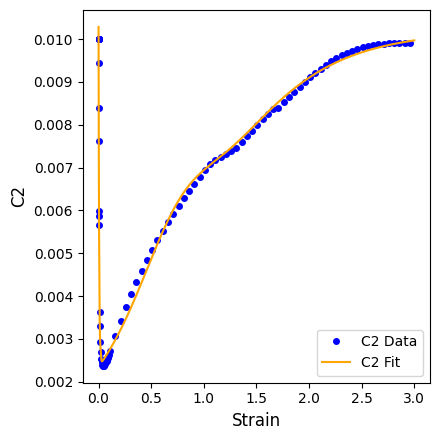

C2 Fit 
Q1=0.000, Q2=0.019, Q3=0.004,
P1=0.008, P2=190.618,
M1=0.001, M2=0.741, M3=-0.316
N1=0.010, N2=1.682
Fitted parameters for C2:

R² Statistics:
R² Value for Fit: 0.996


In [30]:
y_column = 'C2'  # Fitting C2 data

strain = filtered_data[x_column].values
C2 = filtered_data[y_column].values

initial_guess = [
    0.005,  # a
    0.005,  # b
    0.01,   # c
    0.015,  # d
    40.0,   # e
    0.002,  # f
    1.0,    # g
    0.5,    # h
    0.1,    # i
    1.0     # j
]

params, _ = curve_fit(
    func_C, strain, C2, p0=initial_guess, maxfev=100000
)

# Generate fitted C2 values
C2_fitted = func_C(strain, *params)
df_para_fit['C2'] = C2_fitted

# calculate r-squared value

C_residuals = C2 - C2_fitted
ss_res = np.sum(C_residuals ** 2)
ss_tot = np.sum((C2 - np.mean(C2)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.figure(figsize=(4.5,4.5))

lower_mask = (strain >= peeq_lower_bound) & (strain <= 0.01)
plt.plot(strain[lower_mask], C2[lower_mask], 'o', label='C2 Data (Full Range)', markersize=4,color='blue')

# Plot data from 1 to peeq_upper_bound (every 5th value)
upper_mask = (strain > 0.01) & (strain <= peeq_upper_bound)
plt.plot(strain[upper_mask][::5], C2[upper_mask][::5], 'o', label='_nolegend_', markersize=4,color='blue')


plt.plot(strain, C2_fitted, '-', label='C2 Fit', color='orange')  # Fitted curve
plt.xlabel('Strain', fontsize=12)
plt.ylabel('C2', fontsize=12)
plt.legend([
    'C2 Data',     
    'C2 Fit'
        ], fontsize=10,loc='lower right')
plt.tight_layout()
plt.show()


# Print the fitted parameters
print(f'C2 Fit \n'
            f'Q1={params[0]:.3f}, Q2={params[1]:.3f}, Q3={params[2]:.3f},\n'
            f'P1={params[3]:.3f}, P2={params[4]:.3f},\n'
            f'M1={params[5]:.3f}, M2={params[6]:.3f}, M3={params[7]:.3f}\n'
            f'N1={params[8]:.3f}, N2={params[9]:.3f}')

print("Fitted parameters for C2:")

# Print R² statistics
print("\nR² Statistics:")
print(f"R² Value for Fit: {r_squared:.3f}")

# Store parameters
df_para_parameter = pd.DataFrame({x_column: strain})
parameter_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
for i, param in enumerate(params):
    df_para_parameter[parameter_names[i]] = param


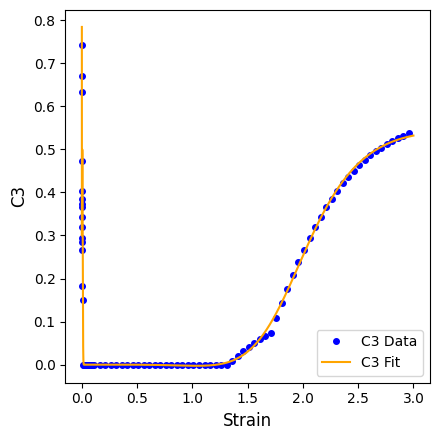

C3 Fit 
Q1=0.500, Q2=0.004, Q3=-0.003,
P1=1.429, P2=8967.808,
M1=-0.073, M2=1.907, M3=0.498
N1=0.544, N2=4.217
Fitted parameters for C3:

R² Statistics:
R² Value for Fit: 0.990


In [31]:
y_column = 'C3'  # Fitting C2 data

strain = filtered_data[x_column].values
C3 = filtered_data[y_column].values

initial_guess = [
    0.1,   # a
    0.001, # b
    0.005, # c
    0.8,   # d
    50.0,  # e
    0.0,   # f
    1.0,   # g
    0.8,   # h
    0.5,   # i:
    2.0    # j
]


params, _ = curve_fit(
    func_C, strain, C3, p0=initial_guess, maxfev=100000
)

C3_fitted = func_C(strain, *params)
df_para_fit['C3'] = C3_fitted

# calculate r-squared value

C_residuals = C3 - C3_fitted
ss_res = np.sum(C_residuals ** 2)
ss_tot = np.sum((C3 - np.mean(C3)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.figure(figsize=(4.5,4.5))

lower_mask = (strain >= peeq_lower_bound) & (strain <= 0.01)
plt.plot(strain[lower_mask], C3[lower_mask], 'o', label='C4 Data (Full Range)', markersize=4,color='blue')

# Plot data from 1 to peeq_upper_bound (every 5th value)
upper_mask = (strain > 0.01) & (strain <= peeq_upper_bound)
plt.plot(strain[upper_mask][::5], C3[upper_mask][::5], 'o', label='_nolegend_', markersize=4,color='blue')


plt.plot(strain, C3_fitted, '-', label='C3 Fit', color='orange')  # Fitted curve
plt.xlabel('Strain', fontsize=12)
plt.ylabel('C3', fontsize=12)
plt.legend([
    'C3 Data',     
    'C3 Fit'
        ], fontsize=10,loc='lower right')
plt.tight_layout()
plt.show()


print(f'C3 Fit \n'
            f'Q1={params[0]:.3f}, Q2={params[1]:.3f}, Q3={params[2]:.3f},\n'
            f'P1={params[3]:.3f}, P2={params[4]:.3f},\n'
            f'M1={params[5]:.3f}, M2={params[6]:.3f}, M3={params[7]:.3f}\n'
            f'N1={params[8]:.3f}, N2={params[9]:.3f}')

print("Fitted parameters for C3:")

# Print R² statistics
print("\nR² Statistics:")
print(f"R² Value for Fit: {r_squared:.3f}")


# Store parameters
df_para_parameter = pd.DataFrame({x_column: strain})
parameter_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
for i, param in enumerate(params):
    df_para_parameter[parameter_names[i]] = param


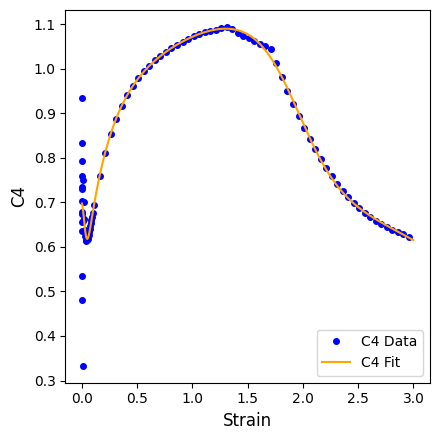

C4 Fit 
Q1=0.225, Q2=-0.012, Q3=0.029,
P1=-0.436, P2=5.034,
M1=0.682, M2=1.947, M3=-2.280
N1=0.453, N2=-4.965
Fitted parameters for C4:

R² Statistics:
R² Value for Fit: 0.975


In [32]:
y_column = 'C4'  # Fitting C2 data

strain = filtered_data[x_column].values
C4 = filtered_data[y_column].values

initial_guess = [
    0.8,   
    0.01, 
    0.01,  
    3.0,   
    20.0,  
    1.2,  
    1.5,  
    0.2,  
    0.3,   
    2.0    
]


params, _ = curve_fit(
    func_C, strain, C4, p0=initial_guess, maxfev=100000
)

# Generate fitted C1 values corresponding to the original strain values
C4_fitted = func_C(strain, *params)
df_para_fit['C4'] = C4_fitted

# calculate r-squared value

C_residuals = C4 - C4_fitted
ss_res = np.sum(C_residuals ** 2)
ss_tot = np.sum((C4 - np.mean(C4)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.figure(figsize=(4.5,4.5))

lower_mask = (strain >= peeq_lower_bound) & (strain <= 0.01)
plt.plot(strain[lower_mask], C4[lower_mask], 'o', label='C4 Data (Full Range)', markersize=4,color='blue')

# Plot data from 1 to peeq_upper_bound (every 5th value)
upper_mask = (strain > 0.01) & (strain <= peeq_upper_bound)
plt.plot(strain[upper_mask][::5], C4[upper_mask][::5], 'o', label='_nolegend_', markersize=4,color='blue')



plt.plot(strain, C4_fitted, '-', label='C4 Fit', color='orange')  # Fitted curve
plt.xlabel('Strain', fontsize=12)
plt.ylabel('C4', fontsize=12)
plt.legend([
    'C4 Data',     
    'C4 Fit'
        ], fontsize=10,loc='lower right')
plt.tight_layout()
plt.show()


print(f'C4 Fit \n'
            f'Q1={params[0]:.3f}, Q2={params[1]:.3f}, Q3={params[2]:.3f},\n'
            f'P1={params[3]:.3f}, P2={params[4]:.3f},\n'
            f'M1={params[5]:.3f}, M2={params[6]:.3f}, M3={params[7]:.3f}\n'
            f'N1={params[8]:.3f}, N2={params[9]:.3f}')

# Print the fitted parameters
print("Fitted parameters for C4:")

# Print R² statistics
print("\nR² Statistics:")
print(f"R² Value for Fit: {r_squared:.3f}")

# Store parameters
df_para_parameter = pd.DataFrame({x_column: strain})
parameter_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
for i, param in enumerate(params):
    df_para_parameter[parameter_names[i]] = param



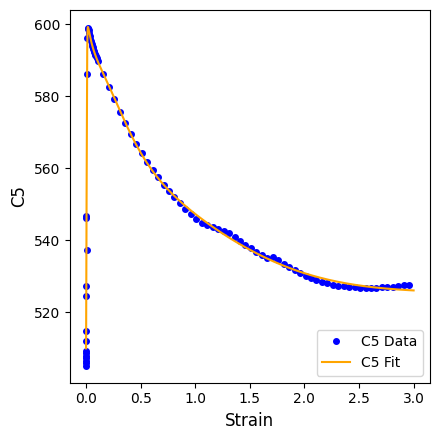

C5 Fit 
Q1=-94.874, Q2=-0.001, Q3=-0.005,
P1=195.922, P2=5.442,
M1=35.530, M2=-0.113, M3=1.087
N1=525.528, N2=7.793
Fitted parameters for C5:

R² Statistics:
R² Value for Fit: 0.996


In [33]:
y_column = 'C5'  # Fitting C2 data

strain = filtered_data[x_column].values
C5 = filtered_data[y_column].values


initial_guess = [
    50.0,   
    0.01,   
    0.05,   
    600.0,  
    1.5,   
    0.5,   
    1.0,    
    0.5,    
    100.0,  
    0.8     
]

params, _ = curve_fit(
    func_C, strain, C5, p0=initial_guess, maxfev=100000
)

# Generate fitted C1 values corresponding to the original strain values
C5_fitted = func_C(strain, *params)
df_para_fit['C5'] = C5_fitted

# calculate r-squared value

C_residuals = C5 - C5_fitted
ss_res = np.sum(C_residuals ** 2)
ss_tot = np.sum((C5 - np.mean(C5)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.figure(figsize=(4.5,4.5))

lower_mask = (strain >= peeq_lower_bound) & (strain <= 0.01)
plt.plot(strain[lower_mask], C5[lower_mask], 'o', label='C5 Data (Full Range)', markersize=4,color='blue')

# Plot data from 1 to peeq_upper_bound (every 5th value)
upper_mask = (strain > 0.01) & (strain <= peeq_upper_bound)
plt.plot(strain[upper_mask][::5], C5[upper_mask][::5], 'o', label='_nolegend_', markersize=4,color='blue')


plt.plot(strain, C5_fitted, '-', label='C5 Fit', color='orange')  # Fitted curve
plt.xlabel('Strain', fontsize=12)
plt.ylabel('C5', fontsize=12)
plt.legend([
    'C5 Data',     
    'C5 Fit'
        ], fontsize=10,loc='lower right')
plt.tight_layout()
plt.show()


print(f'C5 Fit \n'
            f'Q1={params[0]:.3f}, Q2={params[1]:.3f}, Q3={params[2]:.3f},\n'
            f'P1={params[3]:.3f}, P2={params[4]:.3f},\n'
            f'M1={params[5]:.3f}, M2={params[6]:.3f}, M3={params[7]:.3f}\n'
            f'N1={params[8]:.3f}, N2={params[9]:.3f}')

# Print the fitted parameters
print("Fitted parameters for C5:")

# Print R² statistics
print("\nR² Statistics:")
print(f"R² Value for Fit: {r_squared:.3f}")

# Store parameters
df_para_parameter = pd.DataFrame({x_column: strain})
parameter_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
for i, param in enumerate(params):
    df_para_parameter[parameter_names[i]] = param


C:\Temp\ipykernel_24180\3945549568.py:3: RuntimeWarning: overflow encountered in exp
  decay = d * np.exp(-e * s)  # Exponential decay for rapid drop
C:\Temp\ipykernel_24180\3945549568.py:3: RuntimeWarning: overflow encountered in multiply
  decay = d * np.exp(-e * s)  # Exponential decay for rapid drop


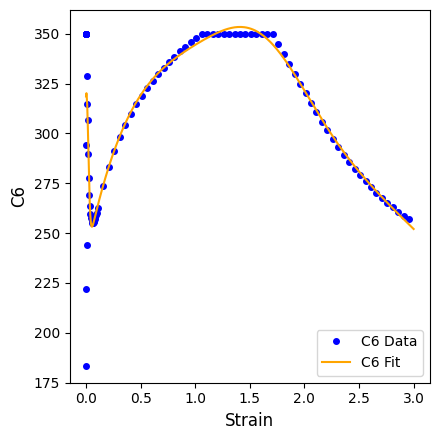

C6 Fit 
Q1=81.628, Q2=0.003, Q3=0.018,
P1=-184.885, P2=1.760,
M1=28.696, M2=1.605, M3=0.403
N1=664.257, N2=-0.348
Fitted parameters for C6:

R² Statistics:
R² Value for Fit: 0.915


In [34]:
y_column = 'C6'  # Fitting C2 data

strain = filtered_data[x_column].values
C6 = filtered_data[y_column].values



initial_guess = [
    0.5,   # a
    0.01,  # b
    0.02,  # c
    4.0,   # d
    60.0,  # e
    2.5,   # f
    1.2,   # g
    0.5,   # h
    5.0,   # i
    2.0    # j
]

# Perform the curve fitting with the adjusted initial guess
params, _ = curve_fit(
    func_C, strain, C6, p0=initial_guess, maxfev=100000
)

# Generate fitted C1 values corresponding to the original strain values
C6_fitted = func_C(strain, *params)
df_para_fit['C6'] = C6_fitted

# calculate r-squared value

C_residuals = C6 - C6_fitted
ss_res = np.sum(C_residuals ** 2)
ss_tot = np.sum((C6 - np.mean(C6)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.figure(figsize=(4.5,4.5))

lower_mask = (strain >= peeq_lower_bound) & (strain <= 0.01)
plt.plot(strain[lower_mask], C6[lower_mask], 'o', label='C6 Data (Full Range)', markersize=4,color='blue')

# Plot data from 1 to peeq_upper_bound (every 5th value)
upper_mask = (strain > 0.01) & (strain <= peeq_upper_bound)
plt.plot(strain[upper_mask][::5], C6[upper_mask][::5], 'o', label='_nolegend_', markersize=4,color='blue')

plt.plot(strain, C6_fitted, '-', label='C6 Fit', color='orange')  # Fitted curve
plt.xlabel('Strain', fontsize=12)
plt.ylabel('C6', fontsize=12)
plt.legend([
    'C6 Data',     
    'C6 Fit'
        ], fontsize=10,loc='lower right')
plt.tight_layout()
plt.show()


# Print the fitted parameters
print(f'C6 Fit \n'
            f'Q1={params[0]:.3f}, Q2={params[1]:.3f}, Q3={params[2]:.3f},\n'
            f'P1={params[3]:.3f}, P2={params[4]:.3f},\n'
            f'M1={params[5]:.3f}, M2={params[6]:.3f}, M3={params[7]:.3f}\n'
            f'N1={params[8]:.3f}, N2={params[9]:.3f}')


print("Fitted parameters for C6:")

# Print R² statistics
print("\nR² Statistics:")
print(f"R² Value for Fit: {r_squared:.3f}")

# Store parameters
df_para_parameter = pd.DataFrame({x_column: strain})
parameter_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
for i, param in enumerate(params):
    df_para_parameter[parameter_names[i]] = param


## Validate

In [35]:
df_para_fit.to_csv('fitted_C1_to_C6.csv', index=False)

In [36]:
file_0001 = r'..\Fitted_FC_TmpDpn_RD_StrRt0.0001_ref.csv'
output_csv_path_0001 = 'fitted_C1_to_C6.csv'
original_data = pd.read_csv(file_0001)
results = pd.read_csv('fitted_C1_to_C6.csv')

#T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
#starting_column = 6 #other strain-rates
starting_column = 8 #0.0001

In [37]:
output_pdf = "6_Parameters_validation.pdf"
output_images_dir = "plots_validation"

os.makedirs(output_images_dir, exist_ok=True)

# Create a PDF object to save plots
pdf_pages = PdfPages(output_pdf)
r_squared_values = []
peeq_values = []

for index, row in results.iterrows():
    peeq = row['PEEQ']  
    params = row[1:7].values  

    # Extract the original data
    stress_original = original_data.iloc[index, starting_column:].values

    # Generate fitted values using the extracted parameters
    def f_func(T_fit, C1, C2, C3, C4, C5, C6):
        return (
            C1 * np.exp(-C2 * T_fit) + C3 +
            C4 * np.exp(-((T_fit - C5) / C6) ** 2)
        )

    # Generate fitted values for a smooth curve
    T_fit = np.linspace(np.min(T), np.max(T), 100)
    stress_fit = f_func(T_fit, *params)
    
    # Calculate R² value
    residuals = stress_original - f_func(T, *params)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((stress_original - np.mean(stress_original)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared_values.append(r_squared)
    peeq_values.append(data.iloc[i, 0])
    
    # Plot both original data and fitted curve
    plt.figure(figsize=(4.5, 5))
    plt.ylim(0.8, 2.4) 

    plt.plot(T, stress_original, 'o', color='blue', label='Data')
       
    plt.plot(T_fit, stress_fit, '-', color='red', label='Fitted Curve')
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('Normalized Stress', fontsize=12)
    plt.title(f"Strain={peeq:.5f} (R² = {r_squared:.3f})", fontweight='bold', fontsize=12)
   
    plt.legend(
            [
                f'Data',
                f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
                f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f}'
            ],
            fontsize=10
        )

    # Save the current figure to the PDF
    pdf_pages.savefig()

    # Save the current figure as an image for video generation
    image_path = os.path.join(output_images_dir, f"plot_{index:03d}.png")
    plt.savefig(image_path, dpi=300)  # High resolution
    plt.close()

# Close the PDF file
pdf_pages.close()
print(f"PDF with original data and fitted curves saved as '{output_pdf}'")
print(f"Plots saved in '{output_images_dir}'")

# Calculate R² statistics
min_r2 = min(r_squared_values)
max_r2 = max(r_squared_values)
avg_r2 = np.mean(r_squared_values)
peeq_min_r2 = peeq_values[r_squared_values.index(min_r2)]
peeq_max_r2 = peeq_values[r_squared_values.index(max_r2)]
# Calculate percentage of R² values larger than 0.9
below = sum(1 for r2 in r_squared_values if r2 > 0.9)
percentage_below = (below / len(r_squared_values)) * 100

    # Print R² statistics
print("\nR² Statistics:")
print(f"Smallest R²: {min_r2:.3f} (PEEQ: {peeq_min_r2:.5f})")
print(f"Largest R²: {max_r2:.3f} (PEEQ: {peeq_max_r2:.5f})")
print(f"Average R²: {avg_r2:.3f}")
print(f"Percentage of R² values below 0.9: {percentage_below:.2f}%")

PDF with original data and fitted curves saved as '6_Parameters_validation.pdf'
Plots saved in 'plots_validation'

R² Statistics:
Smallest R²: -0.047 (PEEQ: 0.00100)
Largest R²: 0.999 (PEEQ: 0.00100)
Average R²: 0.973
Percentage of R² values below 0.9: 97.47%


Plot combined plots

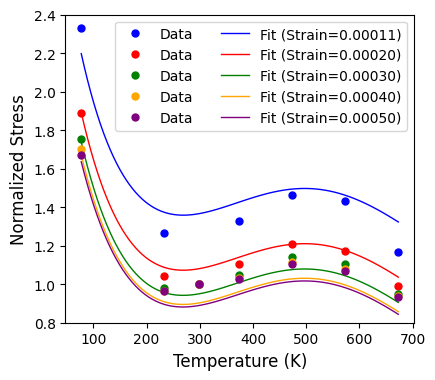

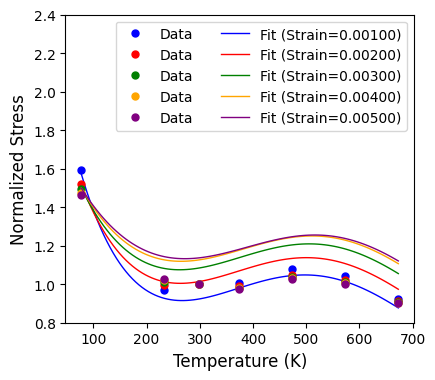

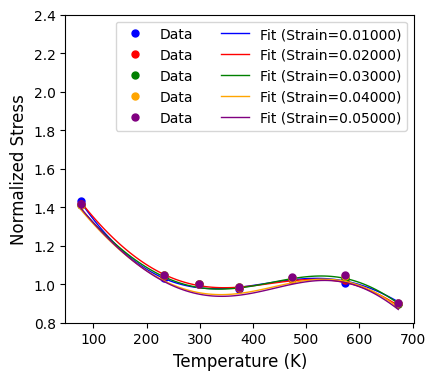

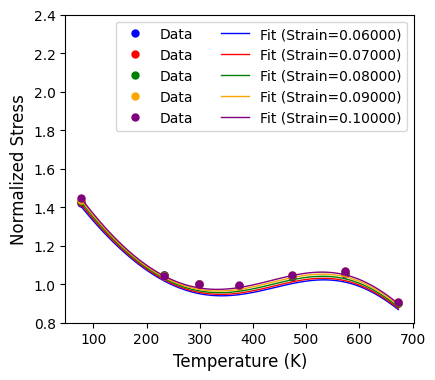

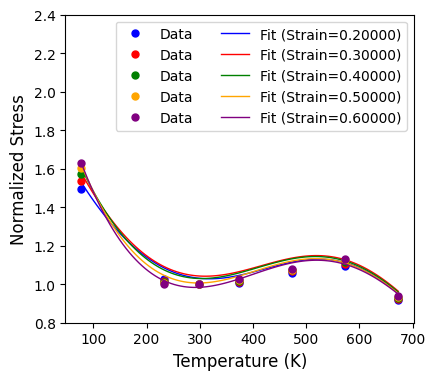

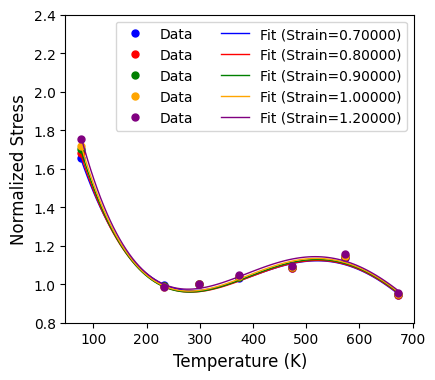

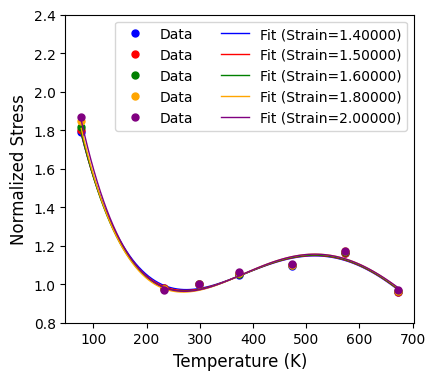

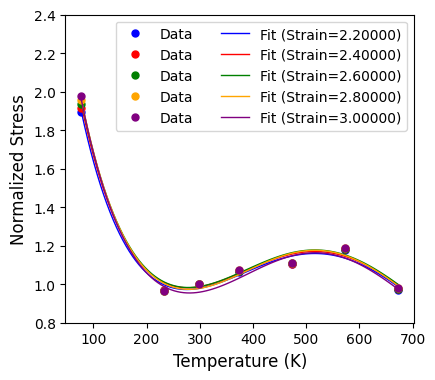

In [38]:

indices = np.array([0,1,2, 3, 4])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([9,10,11, 12, 13])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([14,24,34, 44, 54])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([64,74,84, 94, 104])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([114,124,134, 144, 154])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([164,174,184, 194, 214])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([234,244,254, 274, 294])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

indices = np.array([314,334,354, 374, 394])
generate_combined_plot(output_csv_path_0001, file_0001, T, starting_column, 2.4, indices)

## Extrapolate data for a new temperature

In [39]:
def extrapolate_stress (temperature):
    results = pd.read_csv('fitted_C1_to_C6.csv')
    data_list = []

    for index, row in results.iterrows():
        peeq = row['PEEQ'] 
        params = row[1:7].values  

        # Define the fitting function
        def f_func(T_fit, C1, C2, C3, C4, C5, C6):
            return (
                C1 * np.exp(-C2 * T_fit) + C3 +
                C4 * np.exp(-((T_fit - C5) / C6) ** 2)
            )

        # Calculate the stress fit value
        stress_fit = f_func(temperature, *params)[0]  
        data_list.append([peeq, stress_fit])

 
    output_df = pd.DataFrame(data_list, columns=['PEEQ', 'stress_fit'])

    output_file_path = f'stress_fit_results_{temperature}.csv'
    output_df.to_csv(output_file_path, index=False)

    print(f"Stress fit results saved to '{output_file_path}'")

In [40]:
T1 = np.array([773.15])  # Temperature (K) at strain rate 0.0001
extrapolate_stress (T1)

Stress fit results saved to 'stress_fit_results_[773.15].csv'


In [41]:
T2 = np.array([473.15])  # Temperature (K) at strain rate 0.0001
extrapolate_stress (T2)

Stress fit results saved to 'stress_fit_results_[473.15].csv'
